In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier, LazyRegressor

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

import optuna
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from collections import defaultdict
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix)

import logging
logging.getLogger('lightgbm').setLevel(logging.WARNING)
pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import optuna
from collections import defaultdict
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [91]:
selected_data = help_tool.csv_download(r'Archive\home-credit-default-risk\selected_data.csv').drop(columns='Unnamed: 0')
selected_data.drop(columns=[
    'OCCUPATION_TYPE', 'OWN_CAR_AGE'
    ], inplace=True)

In [9]:
selected_data.loc[selected_data['YEARS_EMPLOYED'] == selected_data['YEARS_EMPLOYED'].min(), 'YEARS_EMPLOYED'] = np.nan

In [10]:
selected_data.loc[selected_data['YEARS_EMPLOYED'] == selected_data['YEARS_EMPLOYED'].min(), 'YEARS_EMPLOYED'] = np.nan

# Bucketing

selected_data['YEARS_BIRTH'] = help_tool.bucket_age_feature(selected_data, 'YEARS_BIRTH')
for feature in ['YEARS_EMPLOYED', 'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 4)

for feature in ['SUM(df.CNT_PAYMENT)', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 5)

selected_data['AMT_GOODS_PRICE'] = help_tool.equal_frequency_bucketing(selected_data, 'AMT_GOODS_PRICE', 3)

In [11]:
for feature in ['Cluster_pos_cash_1']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 3)

In [12]:
for feature in ['AMT_CREDIT']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 5)

In [13]:
for feature in ['EXT_SOURCE_2']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 10)

In [14]:
for feature in ['REGION_POPULATION_RELATIVE']:
    selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 17)

In [15]:
selected_data.columns

Index(['YEARS_BIRTH', 'REGION_RATING_CLIENT', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
       'SUM(df.CNT_PAYMENT)', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'YEARS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE', 'AMT_INCOME_TOTAL',
       'AVG_Risk_Score', 'Cluster_pos_cash_1', 'CODE_GENDER_F',
       'REGION_POPULATION_RELATIVE', 'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH',
       'EXT_SOURCE_3', 'TARGET'],
      dtype='object')

# EXT_SOURCE_1
## LazyPredict
Dummy model will be found via Lazypredict. EXT_SOURCE_3 has a lot of missing values and won't be used.

In [16]:
selected_data.dropna(subset='EXT_SOURCE_1').isna().sum() / selected_data.dropna(subset='EXT_SOURCE_1').shape[0] * 100

YEARS_BIRTH                   0.00
REGION_RATING_CLIENT          0.00
EXT_SOURCE_2                  0.16
EXT_SOURCE_1                  0.00
SUM(df.CNT_PAYMENT)           5.16
AMT_GOODS_PRICE               0.10
AMT_CREDIT                    0.00
YEARS_LAST_PHONE_CHANGE       0.00
NAME_EDUCATION_TYPE           0.00
AMT_INCOME_TOTAL              0.00
AVG_Risk_Score                5.94
Cluster_pos_cash_1            6.02
CODE_GENDER_F                 0.00
REGION_POPULATION_RELATIVE    0.00
YEARS_EMPLOYED                9.59
YEARS_ID_PUBLISH              0.00
EXT_SOURCE_3                 18.18
TARGET                        0.00
dtype: float64

In [17]:
selected_data_EXT_SOURCE_1 = selected_data.dropna(subset='EXT_SOURCE_1').sample(10000, random_state=42)

X = selected_data_EXT_SOURCE_1.drop(columns=['EXT_SOURCE_1', 'TARGET'#, 'EXT_SOURCE_3'
                                             ])
y = selected_data_EXT_SOURCE_1['EXT_SOURCE_1']

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can change the strategy to 'median' or 'most_frequent' if needed
X_imputed = imputer.fit_transform(X)


(X_train, X_vt, y_train, y_vt) = train_test_split(
    X_imputed, y, test_size=0.4, random_state=42)

(X_validation, X_test, y_validation, y_test) = train_test_split(
    X_vt, y_vt, test_size=0.5, random_state=42)


In [18]:
print('X_train', X_train.shape)
print('X_validation', X_validation.shape)
print('X_test', X_test.shape)

X_train (6000, 16)
X_validation (2000, 16)
X_test (2000, 16)


In [19]:
# # Initialize LazyRegressor
# reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# # Fit and evaluate models
# regression_models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# # Print the results
# print(regression_models)

In [20]:
# regression_models
# plt.figure(figsize=(8, 10))

# sns.heatmap(regression_models[(regression_models['Time Taken'] < 50) & (regression_models['ROC AUC'] > 0.52)], annot=True)
# plt.show()

A number of models have similar attributes - hisghest Adjusted R-Squared and R-Squared is 0.45 (R-Squared usually go between 0 and 1, where 1 means hat the model explains all the variability of the response data around its mean). Smallest RMSE is 0.16, where it shows how much error your model typically makes in its predictions, in the same units as the dependent variable.

In this case, lazypredict suggests Ridge reggression model to be one of the best candidates, with the least time consummed. Another great candidate is LinearRegression, these two models will be compared.

## Hyperparameter tunning

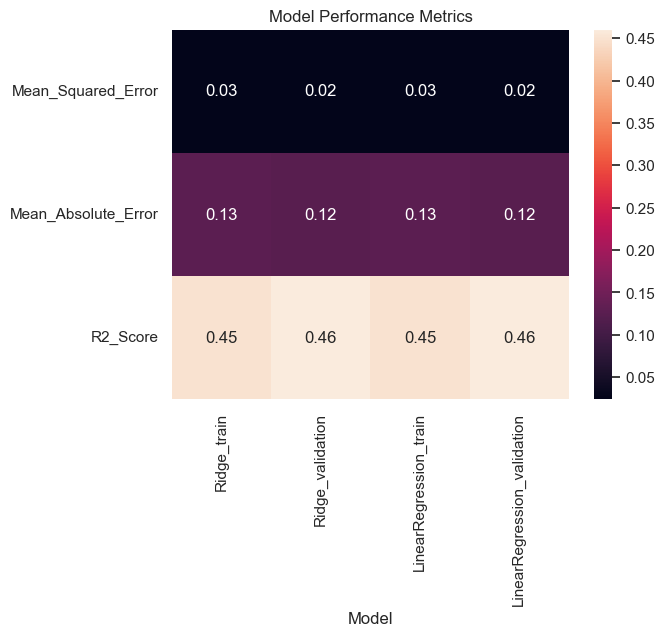

In [21]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Tracking the model suggestions and their respective scores
model_scores = defaultdict(list)
best_scores = {'Ridge': -float('inf'), 'LinearRegression': -float('inf')}
best_params = {'Ridge': None, 'LinearRegression': None}

for model_name in ['Ridge', 'LinearRegression']:
    for _ in range(100):
        trial = study.ask()
        
        if model_name == 'Ridge':
            alpha = trial.suggest_float('alpha', 1e-5, 1e3, log=True)
            model = Ridge(alpha=alpha)
            params = {'model': 'Ridge', 'alpha': alpha}
        elif model_name == 'LinearRegression':
            model = LinearRegression()
            params = {'model': 'LinearRegression'}
        
        # Create a pipeline
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Perform cross-validation and calculate the score
        score = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean()
        model_scores[model_name].append(score)
        
        # Report the score to the study
        study.tell(trial, score)
        
        # Track the best score and parameters for each model type
        if score > best_scores[model_name]:
            best_scores[model_name] = score
            best_params[model_name] = params

# You can also refit the model with the best hyperparameters and validate on the validation set
results = []

for model_name, params in best_params.items():
    if params['model'] == 'Ridge':
        best_model = Ridge(alpha=params['alpha'])
    else:
        best_model = LinearRegression()

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
        ('scaler', StandardScaler()),
        ('model', best_model)
    ])

    if params['model'] == 'Ridge':
        pipeline_ridge = pipeline
    else:
        pipeline_linear = pipeline


    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_validation = pipeline.predict(X_validation)

    results.append({
        'Model': f'{model_name}_train',
        'Mean_Squared_Error': mean_squared_error(y_train, y_pred_train), 
        'Mean_Absolute_Error': mean_absolute_error(y_train, y_pred_train),
        'R2_Score': r2_score(y_train, y_pred_train),       
    })


    results.append({
        'Model': f'{model_name}_validation',
        'Mean_Squared_Error': mean_squared_error(y_validation, y_pred_validation),
        'Mean_Absolute_Error': mean_absolute_error(y_validation, y_pred_validation),
        'R2_Score': r2_score(y_validation, y_pred_validation)     
    })
# Create a DataFrame from the results
model_performance = pd.DataFrame(results)

# Plot the results
sns.heatmap(model_performance.set_index('Model').T, annot=True, fmt=".2f")
plt.title('Model Performance Metrics')
plt.show()


In [22]:
pipeline_ridge.named_steps['model'].alpha

39.71087374376994

Low variability in these scores suggests that the model's performance is stable and not overly dependent on a particular subset of the data.

Cross Validation

In [23]:
from sklearn.model_selection import cross_val_score, KFold


kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline_ridge, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Mean Cross-Validation MSE: ", f'{-cv_scores.mean():.2f}')

print("Standard Deviation of Cross-Validation MSE: ", f'{cv_scores.std():.3f}')

Mean Cross-Validation MSE:  0.03
Standard Deviation of Cross-Validation MSE:  0.002


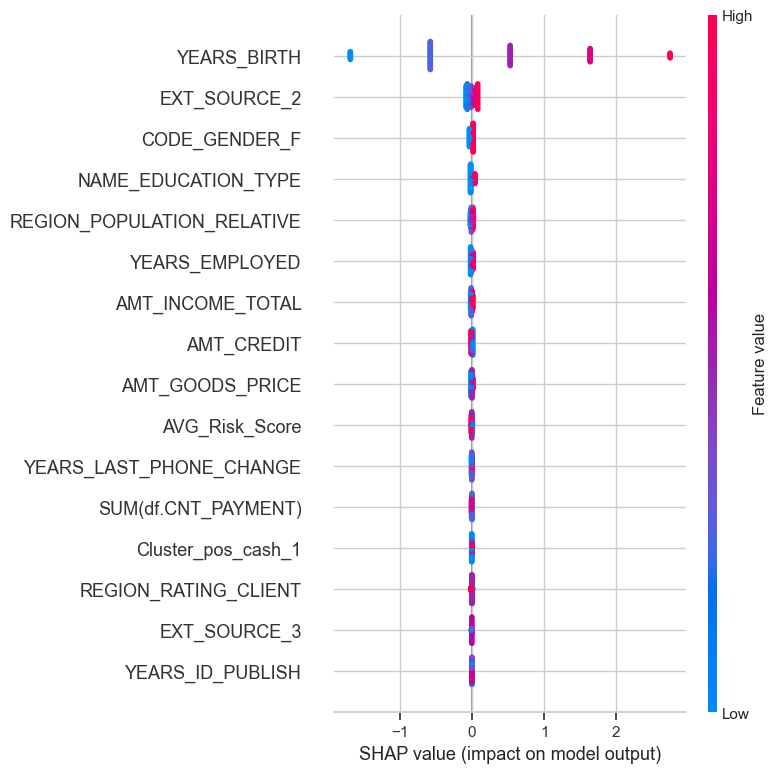

In [24]:
ridge_model = pipeline_ridge.named_steps['model']

feature_names = X.columns   

X_validation_df = pd.DataFrame(X_validation, columns=feature_names)

explainer = shap.Explainer(ridge_model, X_validation_df)

background_sample = X_validation_df.sample(100, random_state=42)

shap_values = explainer.shap_values(background_sample)

shap.summary_plot(shap_values, features=background_sample)

People over 50 years old have a higher EXT_SOURCE_1 rating. It could be related to older people having more time for building up credit.

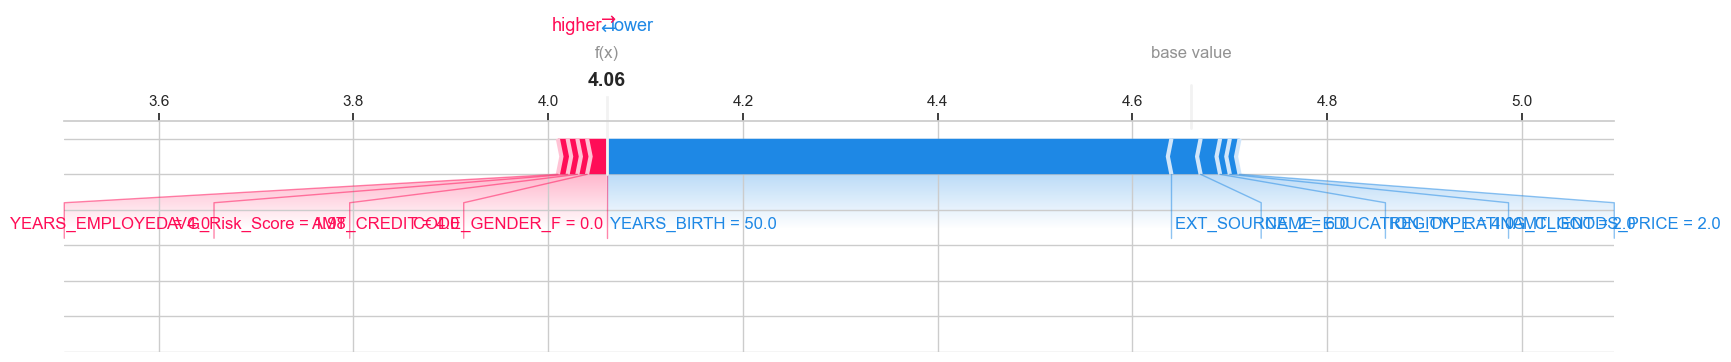

In [25]:
shap.plots.force(explainer.expected_value.round(2), shap_values[1].round(
    2), background_sample.iloc[0, :].round(2), matplotlib=True)

Imputing missing values of EXT_SOURCE_1 with created model

In [26]:
source_1_features = ['YEARS_BIRTH', 'EXT_SOURCE_2', 'CODE_GENDER_F', 'NAME_EDUCATION_TYPE']

In [27]:
selected_data_EXT_SOURCE_1 = selected_data.dropna(subset='EXT_SOURCE_1')#.sample(10000, random_state=42)

X = selected_data_EXT_SOURCE_1[source_1_features]
y = selected_data_EXT_SOURCE_1['EXT_SOURCE_1']


#imputer = SimpleImputer(strategy='mean')
#X_imputed = imputer.fit_transform(X)


(X_train, X_vt, y_train, y_vt) = train_test_split(
    X, y, test_size=0.4, random_state=42)

(X_validation, X_test, y_validation, y_test) = train_test_split(
    X_vt, y_vt, test_size=0.5, random_state=42)

In [28]:
pipeline_ridge.named_steps['model'].alpha

39.71087374376994

In [29]:
best_params.items()

dict_items([('Ridge', {'model': 'Ridge', 'alpha': 39.71087374376994}), ('LinearRegression', {'model': 'LinearRegression'})])

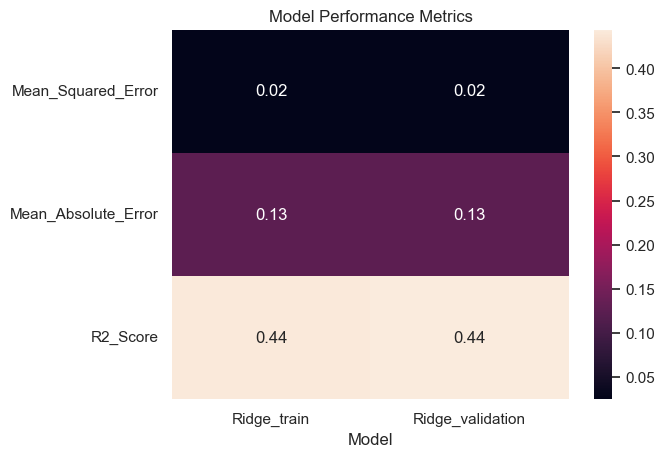

In [30]:
results = []
model_name='Ridge'

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=pipeline_ridge.named_steps['model'].alpha))
])


pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_validation = pipeline.predict(X_validation)

results.append({
    'Model': f'{model_name}_train',
    'Mean_Squared_Error': mean_squared_error(y_train, y_pred_train), 
    'Mean_Absolute_Error': mean_absolute_error(y_train, y_pred_train),
    'R2_Score': r2_score(y_train, y_pred_train),       
})


results.append({
    'Model': f'{model_name}_validation',
    'Mean_Squared_Error': mean_squared_error(y_validation, y_pred_validation),
    'Mean_Absolute_Error': mean_absolute_error(y_validation, y_pred_validation),
    'R2_Score': r2_score(y_validation, y_pred_validation)     
})
# Create a DataFrame from the results
model_performance = pd.DataFrame(results)

# Plot the results
sns.heatmap(model_performance.set_index('Model').T, annot=True, fmt=".2f")
plt.title('Model Performance Metrics')
plt.show()


In [31]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Mean Cross-Validation MSE: ", f'{-cv_scores.mean():.2f}')

print("Standard Deviation of Cross-Validation MSE: ", f'{cv_scores.std():.4f}')

Mean Cross-Validation MSE:  0.02
Standard Deviation of Cross-Validation MSE:  0.0004


Imputing the new data with reversed engeneered EXT_SOURCE_1 values

In [32]:
X_missing_imputed = pipeline.predict(selected_data[selected_data['EXT_SOURCE_1'].isna()][source_1_features])
selected_data.loc[np.isnan(selected_data['EXT_SOURCE_1'].values), 'EXT_SOURCE_1_filled'] = X_missing_imputed
selected_data.loc[selected_data['EXT_SOURCE_1'].notna(), 'EXT_SOURCE_1_filled'] = selected_data['EXT_SOURCE_1']

# TARGET
Dummy model will be found via Lazypredict. But Lazypredict doesn't have build in weights. Instead, downsampled data will be provided.

In [92]:
#selected_data_target = selected_data.drop(columns=['EXT_SOURCE_1']).sample(10000, random_state=42)

selected_data_target = selected_data.sample(10000, random_state=42)


X = selected_data_target.drop(columns=['TARGET'])
y = selected_data_target['TARGET']

class_weights = y.value_counts(normalize=True)
sample_weights = np.where(y == 0, 1 / class_weights[0], 1 / class_weights[1])

(X_train, X_validation, y_train, y_validation, 
 sample_weights_train, sample_weights_validation) = train_test_split(
    X, y, sample_weights, test_size=0.3, random_state=42, stratify=y)

In [148]:
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# classif_models, predictions = clf.fit(X_train, X_validation, y_train, y_validation)

 28%|██▊       | 8/29 [00:01<00:05,  4.10it/s]


KeyboardInterrupt: 

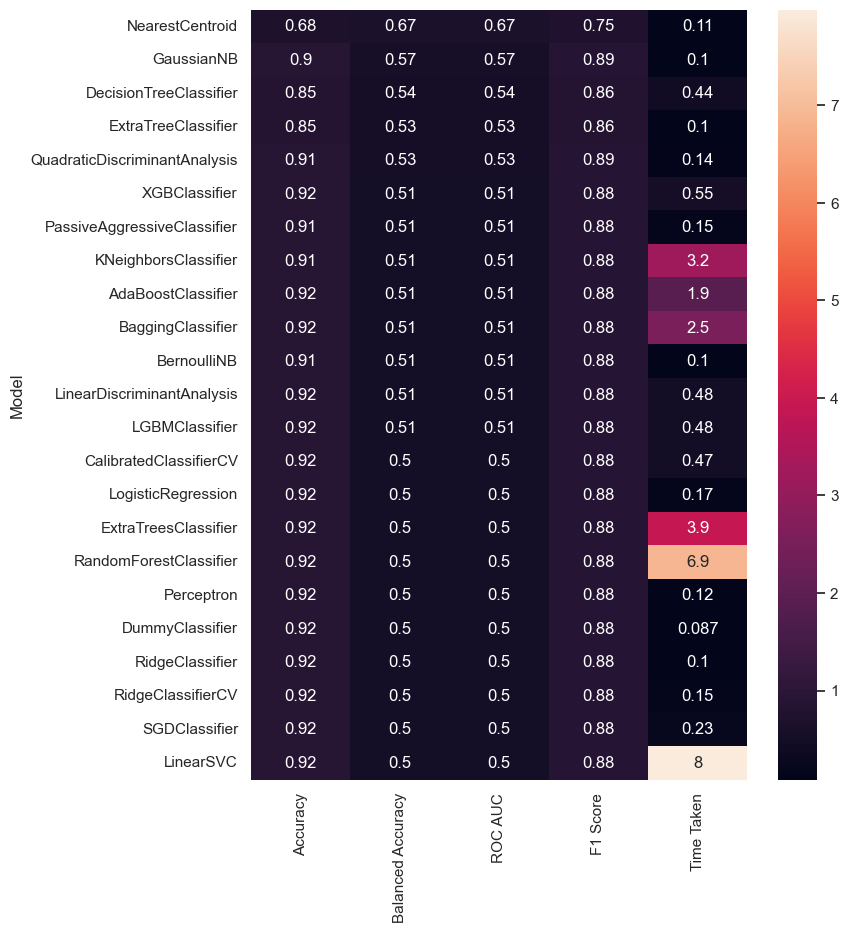

In [19]:
plt.figure(figsize=(8, 10))

sns.heatmap(classif_models[(classif_models['Time Taken'] < 10)], annot=True)
plt.show()

GaussianNB and DecissionTree.

# Model Tuning
Selected models will be hyper parameter and threshold tuned

## Hyperparameted  Tuning
Hyperparameter search is done using Pipeline and RandomizedSearchCV. Different models require different data preparation (i.e. Logistic Regression and KNN requires scaling, while Tree based models require sorting), but because a Pipeline is used, all models are being fed the same StandardScaled data.

After best parameters and models are storred in memory.

In [84]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

In [85]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

In [88]:
classifiers = {

    'Decision Tree': (DecisionTreeClassifier(), {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 5, 10, 15, 20],
        'clf__min_samples_split': [2, 5, 10, 20, 50, 100],
        'clf__min_samples_leaf': [1, 2, 4]
    }),

    'Naive Bayes': (GaussianNB(), {
        'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    }),

    'LightGBM': (LGBMClassifier(), {
        'clf__boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
        'clf__num_leaves': [20, 30, 40, 50],
        'clf__learning_rate': [0.1, 0.01],
        'clf__n_estimators': [100, 200, 300],
        'clf__force_col_wise': [True]
    }),

}

# Loop over each model
for model_name, (model, param_dist) in classifiers.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('clf', model)])

    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=10,
        cv=10,
        random_state=42,
        scoring='f1'
    )

    random_search.fit(X_train, y_train)

    best_clf = random_search.best_estimator_
    best_params = random_search.best_params_

    # Store best model and parameters
    if model_name == 'Radial SVM':
        svm = best_clf
        svm_param = best_params
    elif model_name == 'Linear SVM':
        lsvm = best_clf
        lsvm_param = best_params
    elif model_name == 'Decision Tree':
        dtree = best_clf
        dtree_param = best_params
    elif model_name == 'Random Forest':
        rforest = best_clf
        rforest_param = best_params
    elif model_name == 'KNN':
        knn = best_clf
        knn_param = best_params
    elif model_name == 'Naive Bayes':
        nb = best_clf
        nb_param = best_params
    elif model_name == 'XGBoost':
        xgb = best_clf
        xgb_param = best_params
    elif model_name == 'LightGBM':
        lgbm = best_clf
        lgbm_params = best_params
    elif model_name == 'Logistic Regression':
        logreg = best_clf
        logreg_params = best_params

    print(f"Best Hyperparameters for {model_name}: {best_params}")

    accuracy_train = accuracy_score(y_train, best_clf.predict(X_train))
    accuracy_validation = accuracy_score(
        y_validation, best_clf.predict(X_validation))

    print(
        f"Validation Accuracy for {model_name}: {accuracy_train:.2f}/{accuracy_validation:.2f}")

Best Hyperparameters for Decision Tree: {'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_depth': 15, 'clf__criterion': 'gini'}
Validation Accuracy for Decision Tree: 0.94/0.88


ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\naive_bayes.py", line 263, in fit
    return self._partial_fit(
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\naive_bayes.py", line 423, in _partial_fit
    X, y = self._validate_data(X, y, reset=first_call)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\utils\validation.py", line 1049, in check_array
    _assert_all_finite(
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\utils\validation.py", line 126, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\sklearn\utils\validation.py", line 175, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GaussianNB does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [89]:
# Define classifiers and their parameter grids
classifiers = {
    'Decision Tree': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 20, 50, 100],
        'min_samples_leaf': [1, 2, 4]
    }),
    # 'Random Forest': (RandomForestClassifier(), {
    #     'n_estimators': list(range(100, 1000, 10)),
    #     'max_depth': list(range(1, 110, 10)),
    #     'max_features': ['sqrt', 'log2'],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4],
    #     'bootstrap': [True, False]
    # }),
    'Naive Bayes': (GaussianNB(), {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    }),
    'LightGBM': (LGBMClassifier(), {
        'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
        'num_leaves': [20, 30, 40, 50],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200, 300],
        'force_col_wise': [True],
        'bagging_fraction': [0.8, 0.9, 1.0],  
        'feature_fraction': [0.8, 0.9, 1.0]
    })
}

In [53]:
import lightgbm as lgb
import logging

logger = logging.getLogger('lightgbm')
logger.setLevel(logging.ERROR)  # Adjust logging level as needed

In [93]:
# classifiers = {
#     "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [3, 5, 7]}),
#     "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [3, 5, 7]})
# }


for clf_name, (clf, param_grid) in classifiers.items():
    print(f"Tuning hyperparameters for {clf_name}...")

    if clf_name == 'Decision Tree':
        dtree_param = help_model.optimize_hyperparameters(clf_name, clf, param_grid, X, y)
    elif clf_name == 'Naive Bayes':
        nbayers_param = help_model.optimize_hyperparameters(clf_name, clf, param_grid, X, y)
    elif clf_name == 'LightGBM':
        lightxgb_param = help_model.optimize_hyperparameters(clf_name, clf, param_grid, X, y)   


Tuning hyperparameters for Decision Tree...
Best Decision Tree parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Decision Tree f1_score: 0.23
Tuning hyperparameters for Naive Bayes...
Best Naive Bayes parameters: {'var_smoothing': 1e-08}
Best Naive Bayes f1_score: 0.22
Tuning hyperparameters for LightGBM...
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 647, number of negative: 7353
[LightGBM] [Info] Total Bins 2861
[LightGBM] [Info] Number of data points in the train

In [75]:
dtree_param

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 50,
 'min_samples_leaf': 2}

## Threshold Tuning
After finding the best Hyperparameters, Optimal Thresholds will be found and stored in a dataframe.

In [76]:
# Example data preparation
selected_data_target = selected_data.drop(columns=['EXT_SOURCE_1']).sample(10000, random_state=42)
X = selected_data_target.drop(columns=['TARGET'])
y = selected_data_target['TARGET']

# Compute class weights and sample weights
class_weights = y.value_counts(normalize=True)
sample_weights = np.where(y == 0, 1 / class_weights[0], 1 / class_weights[1])

# Train-test split with sample weights
X_train, X_validation, y_train, y_validation, sample_weights_train, sample_weights_validation = train_test_split(
    X, y, sample_weights, test_size=0.3, random_state=42, stratify=y)


classifiers = {
    'Decision Tree': (DecisionTreeClassifier(**dtree_param), dtree_param),
    'Naive Bayes': (GaussianNB(), nbayers_param),
    'LightGBM': (LGBMClassifier(**lightxgb_param), lightxgb_param),
}

for model_name, (model, params) in classifiers.items():
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()), 
        ('clf', model)  # 'clf' can be any name you choose for the classifier step
    ])

    # Fit the pipeline
    fitted_model = pipeline.fit(X_train, y_train, clf__sample_weight=sample_weights_train)

    # Store best model and parameters
    if model_name == 'Decision Tree':
        dtree = fitted_model
    elif model_name == 'Naive Bayes':
        nb = fitted_model
    elif model_name == 'LightGBM':
        lgbm = fitted_model


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 566, number of negative: 6434
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500192 -> initscore=0.000769
[LightGBM] [Info] Start training from score 0.000769


## Threshold Tuning
After finding the best Hyperparameters, Optimal Thresholds will be found and stored in a dataframe.

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


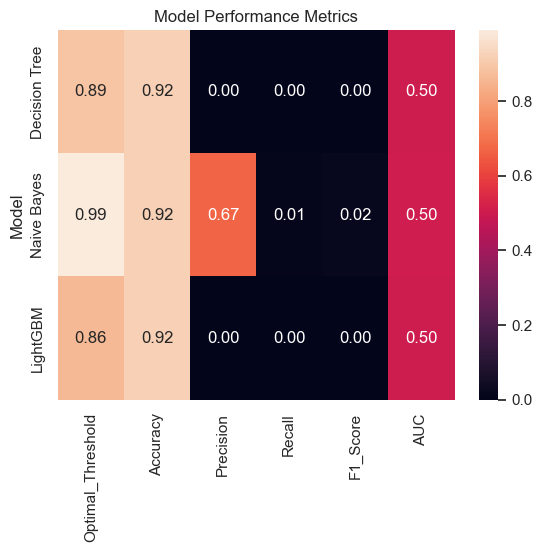

In [78]:
classifier_models = {
    'dtree': {'model': dtree, 'label': 'Decision Tree'},
    'nb': {'model': nb, 'label': 'Naive Bayes'},
    'lgbm': {'model': lgbm, 'label': 'LightGBM'},
}

results = []

for name, model_info in classifier_models.items():
    model = model_info['model']
    label = model_info['label']

    # Create thresholds for decision threshold tuning
    thresholds = np.linspace(0, 1, 100)

    # Initialize variables to track best accuracy and threshold
    best_accuracy = 0
    optimal_threshold = 0

    y_proba = help_tool.predict_proba_available(model, X_validation)

    # Find optimal threshold based on accuracy
    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        accuracy = accuracy_score(y_validation, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            optimal_threshold = threshold

    # Use the optimal threshold to predict final labels
    y_pred_optimal = (y_proba > optimal_threshold).astype(int)

    results.append({'Model': label,
                    'Optimal_Threshold': optimal_threshold,
                    'Accuracy': accuracy_score(y_validation, y_pred_optimal),
                    'Precision': precision_score(y_validation, y_pred_optimal),
                    'Recall': recall_score(y_validation, y_pred_optimal),
                    'F1_Score': f1_score(y_validation, y_pred_optimal),
                    'AUC': roc_auc_score(y_validation, y_pred_optimal)
                    })

model_threshol_search = pd.DataFrame(results)


sns.heatmap(model_threshol_search.set_index(
    'Model'), annot=True, fmt=".2f")
plt.title('Model Performance Metrics')
plt.show()